<a href="https://colab.research.google.com/github/fblondiaux/LGBIO2060-2020/blob/TP4-Draft/LGBIO2060_TP4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LGBIO2060 - Exercise session 4
Kalman filtering or how to implement the prior and likelihood dynamically? 


## Import and helper functions
**Please execute the cell below to initialize the notebook environment**

In [ ]:
#@title Imports
import numpy as np
import matplotlib.pyplot as plt

## Tutorial objectives 

At the end of this tutorial, you should be able to understand the 

# Section 1 - Model Formulation

In [ ]:
N = 50  # Nb of steps

dt = 0.01
kv = 0.1
tau = 0.05
lamb = 0
ns = 10
A = np.array([(1, 0, dt, 0, 0, 0, 0, 0, 0, 0),
              (0, 1, 0, dt, 0, 0, 0, 0, 0, 0),
              (0, 0, 1 - dt * kv, 0, dt, 0, 0, 0, 0, 0),
              (0, 0, 0, 1 - dt * kv, 0, dt, 0, 0, 0, 0),
              (0, 0, 0, 0, 1 - (dt / tau), 0, 0, 0, 0, 0),
              (0, 0, 0, 0, 0, 1 - (dt / tau), 0, 0, 0, 0),
              (0, 0, 0, 0, 0, 0, 1, 0, 0, 0),
              (0, 0, 0, 0, 0, 0, 0, 1, 0, 0),
              (0, 0, 0, 0, 0, 0, 0, 0, 1, 0),
              (0, 0, 0, 0, 0, 0, 0, 0, 0, 1)])
B = np.array([(0, 0),
              (0, 0),
              (0, 0),
              (0, 0),
              (dt / tau, lamb * dt / tau),
              (lamb * dt / tau, dt / tau),
              (0, 0),
              (0, 0),
              (0, 0),
              (0, 0)])

## Section 2 - Cost Function

In [ ]:
w1 = 100
w2 = 100
w3 = 10
w4 = 10
QN = np.array([(w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0),
               (0, w2, 0, 0, 0, 0, 0, -w2, 0, 0),
               (0, 0, w3, 0, 0, 0, 0, 0, -w3, 0),
               (0, 0, 0, w4, 0, 0, 0, 0, 0, -w4),
               (0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
               (0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
               (-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0),
               (0, -w2, 0, 0, 0, 0, 0, w2, 0, 0),
               (0, 0, -w3, 0, 0, 0, 0, 0, w3, 0),
               (0, 0, 0, -w4, 0, 0, 0, 0, 0, w4)])
R = np.array([(10 ** -4, 0), (0, 10 ** -4)])

## Section 3 - Optimal Control

Now that our system is defined and that we have our cost function, we want to find the control sequence $u_1$, $u_2$, $u_3$, ... $u_n$ that minimizes the cost. From all the motor commands we can do to reach our goal, we want to find the most optimal. 

The solution of this problem ([proof here]()) is given by the following **backward** recursion.

\begin{eqnarray}
S_N &=& Q_N, \qquad s_N = 0,\\
L_k &=& \left(R+B^TS_{k+1}B\right)^{-1}B^TS_{k+1}A,\\
S_k &=& Q_k + A^TS_{k+1}(A-BL_k).
\end{eqnarray}

We can simulate the system forward since the control signal is defined as $u_k = -L_k x_k$, the dynamics becomes:

\begin{eqnarray}
x_{k+1} = (A-BL_k)x_k + \textrm{noise}.
\end{eqnarray}

The noise term correspond to the 

In [ ]:
L = np.zeros((N, 2, ns))
S = np.zeros((N, ns, ns))
Q = np.zeros((N, ns, ns))
Q[N - 1, :, :] = QN
S[N - 1, :, :] = QN

for i in range(N - 1, 0, -1):
    L[i - 1, :, :] = np.linalg.inv(R + B.T @ S[i, :, :] @ B) @ B.T @ S[i, :, :] @ A 
    S[i - 1, :, :] = Q[i - 1] + A.T @ S[i, :, :] @ (A - B @ L[i - 1, :, :])


Using the control gains you have computed above, you can already simulate some movements, try to set a goal and run your code to see if this model behaves as you would expect.

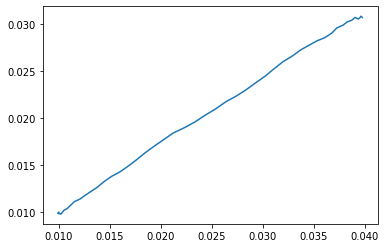

In [ ]:
X = np.zeros((N, ns, 1))

#set a goal
X[0, :, :] = [[0.01], [0.01], [0], [0], [0], [0], [0.04], [0.03], [0], [0]]

#compute the motor noise 
Xi = np.random.normal(loc=0, scale=10 ** -4, size=(N, 10, 1))
for j in range(0, N - 1):
    X[j + 1, :, :] = ((A - B @ L[j, :, :]) @ X[j, :, :]) + Xi[j, :, :]

plt.plot(X[:, 0, :],X[:, 1, :])

##Section 4 - State Estimation




Once again, our sensory inputs are not good enough to infer the position of the fly we are tracking. In order to have a better estimation of the fly's position at every time, we will use a continuous adaptation of Bayes' theorem: the **Kalman filter**. 

At every time step, the Kalman filter computes the weighted sum of the prior and the likelihood, weighted by a factor that characterises how trustable each term is. The result of this weighted sum will be the posterior distribution; this posterior distribution is the optimal estimator of the latent state of the system. 

The estimated state, denoted $\hat{x}$ is computed this way : 

$\begin{eqnarray}
& & \\
\hat{x}[t] & = & \text{trust}_{\text{prior}}x_{\text{prior}} + \text{trust}_{\text{likelihood}}x_{\text{likelihood}}\\
& & \\
\hat{x}[t+1] & = & A  \hat{x}[t]+ K[t]\left(y[t] - H \hat{x}[t]\right)\\
& & \\
\end{eqnarray}$

Where $K[t]$ is the Kalman gain evaluated at time $t$. These Kalman gains will be the weighting parameters that characterises how much we trust one source of information (prior and likelihood) over the other. Since these gains quantifies the trust we have in each source, they will be computed based on the covariances matrices of these two sources. The covariance matrix related to the prior is $\Omega_{\text{motor}}$ and the one related to the likelihood is $\Omega_{\text{sensory}}$. Therefore the gain of the kalman filter are recursively computed as follows:  

$\begin{eqnarray}
& & \\
K[t]& = &A\, \Sigma[t] \,H^T \left(H \,\Sigma[T]\,H^T+\Omega_{\text{motor}}\right)^{-1} \\
& & \\
\Sigma[t+1] & = & \Omega_{\text{sensory}} + \left(A-K[t]\,H\right)\Sigma[T]\,A^T
\end{eqnarray}$

Where $\Sigma[t] = \mathbb{C}\text{ov}\left\{\hat{x}[t]\right\}$ is the covariance matrix of the estimated state at time t. 


**Exercice 3 - Implement the function below to apply Kalman filter to the dynamical linear system**


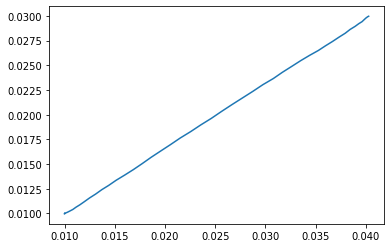

In [ ]:
Xhat = np.zeros((N, ns, 1))
Xhat[0, :, :] = X[0, :, :]

Y = np.zeros((N, ns, 1))
U = np.zeros((N,2,1))

Sigma = np.zeros((N, ns, ns))
Sigma[0,:,:] = np.eye(ns)*10**-6

K = np.zeros((N, ns, ns))
H = np.eye(ns)

Xi = np.random.normal(loc=0, scale=10 ** -4, size=(N, ns, 1))
Omega = np.random.normal(loc=0, scale=10 ** -2, size=(N, ns, 1))
oXi = 0.1 * (B @ B.T)
oOmega = 0.1 * np.max(np.max(oXi)) * np.eye(ns)

for j in range(0, N - 1):
    X[j + 1, :, :] = ((A - B @ L[j, :, :]) @ X[j, :, :]) + Xi[j, :, :]
    Y[j, :, :] = H @ X[j] + Omega[j, :, :]
    K[j,:,:] = A @ Sigma[j,:,:] @ H.T @ np.linalg.inv(H@Sigma[j,:,:] @H.T + oOmega)
    Sigma[j + 1, :, :] = oXi + (A - K[j, :, :] @ H) @ Sigma[j, :, :] @ A.T
    U[j,:,:] = - L[j,:,:] @ Xhat[j,:,:]
    Xhat[j+1,:,:] = A @ Xhat[j,:,:] + B @ U[j,:,:] + K[j,:,:] @ (Y[j,:,:] - H @ Xhat[j,:,:] )

plt.plot(Xhat[:, 0, :],Xhat[:, 1, :])